In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.autograd import Variable
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [2]:
CUDA = torch.cuda.is_available()
device = torch.device("cuda" if CUDA else "cpu")
print(device)

cuda


In [3]:
vgg_arch16 = [64, 64, "M", 128, 128, "M", 256, 256, 256, "M", 512, 512, 512, "M", 512, 512, 512, "M"]


In [4]:
class VGGNet(nn.Module):
    def __init__(self, vgg_arch, num_classes):
        super(VGGNet, self).__init__()
        self.features = self.vgg_block(vgg_arch)

        self.fc1 = nn.Linear(in_features=512*7*7, out_features=4096)
        self.fc2 = nn.Linear(in_features=4096, out_features=1024)
        self.fc3 = nn.Linear(in_features=1024, out_features=num_classes)

    def vgg_block(self, vgg_arch):
        layers = []
        in_channels = 3 

        for v in vgg_arch:
            if v == "M":
            layers.append(nn.MaxPool2d(kernel_size=2, stride=2))

            else:
            layers.append(nn.Conv2d(in_channels=in_channels, out_channels=v, kernel_size=3, padding=1))
            layers.append(nn.ReLU(inplace=True)) 
            in_channels = v

        return nn.Sequential(*layers)       

    def forward(self, x):
        x = self.features(x)
        
        # x = x.view(x.size(0), -1)
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [5]:
# Parameters
batch_size = 16
num_epochs = 30
lr = 0.001

num_classes=2
model = VGGNet(vgg_arch16, num_classes)

if CUDA:
    model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

In [6]:
import json
import zipfile
import os

# kaggle api
api_token = {"username":"aaa","key":"kkk"}
 
if not os.path.exists("/root/.kaggle"):
    os.makedirs("/root/.kaggle")

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)
!chmod 600 /root/.kaggle/kaggle.json
 
if not os.path.exists("/kaggle"):
    os.makedirs("/kaggle")
os.chdir('/kaggle')
!kaggle datasets download -d chetankv/dogs-cats-images --force
 
!ls /kaggle

100% 433M/435M [00:12<00:00, 35.9MB/s]
100% 435M/435M [00:12<00:00, 37.4MB/s]
dogs-cats-images.zip


In [7]:
!unzip dogs-cats-images.zip

串流輸出內容已截斷至最後 5000 行。
  inflating: dog vs cat/dataset/training_set/cats/cat.370.jpg  
  inflating: dog vs cat/dataset/training_set/cats/cat.3700.jpg  
  inflating: dog vs cat/dataset/training_set/cats/cat.3701.jpg  
  inflating: dog vs cat/dataset/training_set/cats/cat.3702.jpg  
  inflating: dog vs cat/dataset/training_set/cats/cat.3703.jpg  
  inflating: dog vs cat/dataset/training_set/cats/cat.3704.jpg  
  inflating: dog vs cat/dataset/training_set/cats/cat.3705.jpg  
  inflating: dog vs cat/dataset/training_set/cats/cat.3706.jpg  
  inflating: dog vs cat/dataset/training_set/cats/cat.3707.jpg  
  inflating: dog vs cat/dataset/training_set/cats/cat.3708.jpg  
  inflating: dog vs cat/dataset/training_set/cats/cat.3709.jpg  
  inflating: dog vs cat/dataset/training_set/cats/cat.371.jpg  
  inflating: dog vs cat/dataset/training_set/cats/cat.3710.jpg  
  inflating: dog vs cat/dataset/training_set/cats/cat.3711.jpg  
  inflating: dog vs cat/dataset/training_set/cats/cat.3712.jpg  
  infl

In [9]:
# Transform
transform = transforms.Compose(
                [transforms.Resize(size=(227,227)),
                 transforms.CenterCrop(224),
                 transforms.RandomRotation(20),
                  transforms.RandomHorizontalFlip(),
                 transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,)),]
                )

# Data
train_dataset = datasets.ImageFolder(root='/kaggle/dataset/training_set', transform=transform)
valid_dataset = datasets.ImageFolder(root='/kaggle/dataset/test_set', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

In [10]:
def train(train_loader, model, criterion, optimizer, epoch):
    model.train()
    total_train = 0
    correct_train = 0
    train_loss = 0
    
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = Variable(data), Variable(target) 
        
        if CUDA:
            data, target = data.cuda(), target.cuda()

        # clear gradient
        optimizer.zero_grad()

        # Forward propagation
        output = model(data) 
        loss = criterion(output, target) 

        # Calculate gradients
        loss.backward()

        # Update parameters
        optimizer.step()

        predicted = torch.max(output.data, 1)[1]
        total_train += len(target)
        correct_train += sum((predicted == target).float())
        train_loss += loss.item()

        if batch_idx % 100 == 0:
            print("Train Epoch: {}/{} [iter： {}/{}], acc： {:.6f}, loss： {:.6f}".format(
               epoch+1, num_epochs, batch_idx+1, len(train_loader),
               correct_train / float((batch_idx + 1) * batch_size),
               train_loss / float((batch_idx + 1) * batch_size)))
            
    train_acc_ = 100 * (correct_train / float(total_train))
    train_loss_ = train_loss / total_train
                    
    return train_acc_, train_loss_

In [11]:
def validate(valid_loader, model, criterion, epoch): 
    model.eval()
    total_valid = 0
    correct_valid = 0
    valid_loss = 0
    
    for batch_idx, (data, target) in enumerate(valid_loader):
        data, target = Variable(data), Variable(target) 
        
        if CUDA:
            data, target = data.cuda(), target.cuda()

        output = model(data)
        loss = criterion(output, target) 

        predicted = torch.max(output.data, 1)[1]
        total_valid += len(target)
        correct_valid += sum((predicted == target).float())
        valid_loss += loss.item()

        if batch_idx % 100 == 0:
            print("Valid Epoch: {}/{} [iter： {}/{}], acc： {:.6f}, loss： {:.6f}".format(
               epoch+1, num_epochs, batch_idx+1, len(valid_loader),
               correct_valid / float((batch_idx + 1) * batch_size),
               valid_loss / float((batch_idx + 1) * batch_size)))
            
    valid_acc_ = 100 * (correct_valid / float(total_valid))
    valid_loss_ = valid_loss / total_valid
                    
    return valid_acc_, valid_loss_

In [12]:
def training_loop(model, criterion, optimizer, train_loader, valid_loader):
    # set objects for storing metrics
    total_train_loss = []
    total_valid_loss = []
    total_train_accuracy = []
    total_valid_accuracy = []
 
    # Train model
    for epoch in range(num_epochs):
        # training
        train_acc_, train_loss_ = train(train_loader, model, criterion, optimizer, epoch)
        total_train_loss.append(train_loss_)
        total_train_accuracy.append(train_acc_)

        # validation
        with torch.no_grad():
            valid_acc_, valid_loss_ = validate(valid_loader, model, criterion, epoch)
            total_valid_loss.append(valid_loss_)
            total_valid_accuracy.append(valid_acc_)

        print('==========================================================================')
        print("Epoch: {}/{}， Train acc： {:.6f}， Train loss： {:.6f}， Valid acc： {:.6f}， Valid loss： {:.6f}".format(
               epoch+1, num_epochs, 
               train_acc_, train_loss_,
               valid_acc_, valid_loss_))
        print('==========================================================================')

    print("====== END ==========")

    return total_train_loss, total_valid_loss, total_train_accuracy, total_valid_accuracy

In [13]:
total_train_loss, total_valid_loss, total_train_accuracy, total_valid_accuracy = training_loop(model, criterion, optimizer, train_loader, valid_loader)

Train Epoch: 1/30 [iter： 1/500], acc： 0.625000, loss： 0.043072
Train Epoch: 1/30 [iter： 101/500], acc： 0.507426, loss： 0.045267
Train Epoch: 1/30 [iter： 201/500], acc： 0.501244, loss： 0.044312
Train Epoch: 1/30 [iter： 301/500], acc： 0.496678, loss： 0.043989
Train Epoch: 1/30 [iter： 401/500], acc： 0.495636, loss： 0.043824
Valid Epoch: 1/30 [iter： 1/125], acc： 1.000000, loss： 0.043166
Valid Epoch: 1/30 [iter： 101/125], acc： 0.618812, loss： 0.043285
Epoch: 1/30， Train acc： 49.312504， Train loss： 0.043728， Valid acc： 50.000000， Valid loss： 0.043322
Train Epoch: 2/30 [iter： 1/500], acc： 0.625000, loss： 0.043283
Train Epoch: 2/30 [iter： 101/500], acc： 0.519802, loss： 0.043310
Train Epoch: 2/30 [iter： 201/500], acc： 0.514303, loss： 0.043313
Train Epoch: 2/30 [iter： 301/500], acc： 0.507267, loss： 0.043322
Train Epoch: 2/30 [iter： 401/500], acc： 0.505299, loss： 0.043323
Valid Epoch: 2/30 [iter： 1/125], acc： 0.000000, loss： 0.043828
Valid Epoch: 2/30 [iter： 101/125], acc： 0.381188, loss： 0.04344

In [14]:
def plot_result(total_train, total_valid, label):
    plt.plot(range(num_epochs), total_train, 'b-', label=f'Training_{label}')
    plt.plot(range(num_epochs), total_valid, 'g-', label=f'validation_{label}')
    plt.title(f'Training & Validation {label}')
    plt.xlabel('Number of epochs')
    plt.ylabel(f'{label}')
    plt.legend()
    plt.show()

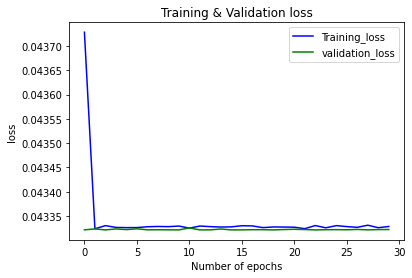

In [15]:
plot_result(total_train_loss, total_valid_loss, 'loss')

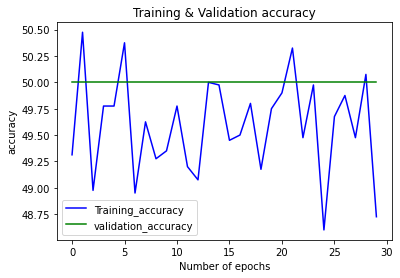

In [16]:
plot_result(total_train_accuracy, total_valid_accuracy, 'accuracy')